In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)


for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False


class_names = ['Angry', 'Other', 'Sad', 'happy']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [6]:
!pip install torchinfo

In [7]:
from torchinfo import summary


summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 4]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [8]:

train_dir = '/content/drive/MyDrive/Pet_Facial/Master Folder/train'
test_dir = '/content/drive/MyDrive/Pet_Facial/Master Folder/valid'

In [9]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [10]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):


  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

 
  class_names = train_data.classes

  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [11]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=32
)

In [12]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78aa105edc90>,
 ['Angry', 'Other', 'Sad', 'happy'])

In [13]:
from going_modular.going_modular import engine

# optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier 
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=50,
                                      device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2304 | train_acc: 0.4365 | test_loss: 1.2168 | test_acc: 0.4375
Epoch: 2 | train_loss: 0.9736 | train_acc: 0.6309 | test_loss: 1.2352 | test_acc: 0.4531
Epoch: 3 | train_loss: 0.8323 | train_acc: 0.7354 | test_loss: 1.2564 | test_acc: 0.4531
Epoch: 4 | train_loss: 0.7411 | train_acc: 0.7627 | test_loss: 1.3165 | test_acc: 0.4531
Epoch: 5 | train_loss: 0.6696 | train_acc: 0.7939 | test_loss: 1.3236 | test_acc: 0.4531
Epoch: 6 | train_loss: 0.6052 | train_acc: 0.8359 | test_loss: 1.3753 | test_acc: 0.4844
Epoch: 7 | train_loss: 0.5572 | train_acc: 0.8330 | test_loss: 1.3938 | test_acc: 0.4688
Epoch: 8 | train_loss: 0.5105 | train_acc: 0.8701 | test_loss: 1.4726 | test_acc: 0.4844
Epoch: 9 | train_loss: 0.4765 | train_acc: 0.8799 | test_loss: 1.4701 | test_acc: 0.4688
Epoch: 10 | train_loss: 0.4512 | train_acc: 0.8857 | test_loss: 1.5087 | test_acc: 0.4844
Epoch: 11 | train_loss: 0.4192 | train_acc: 0.9102 | test_loss: 1.5801 | test_acc: 0.4844
Epoch: 12 | train_l

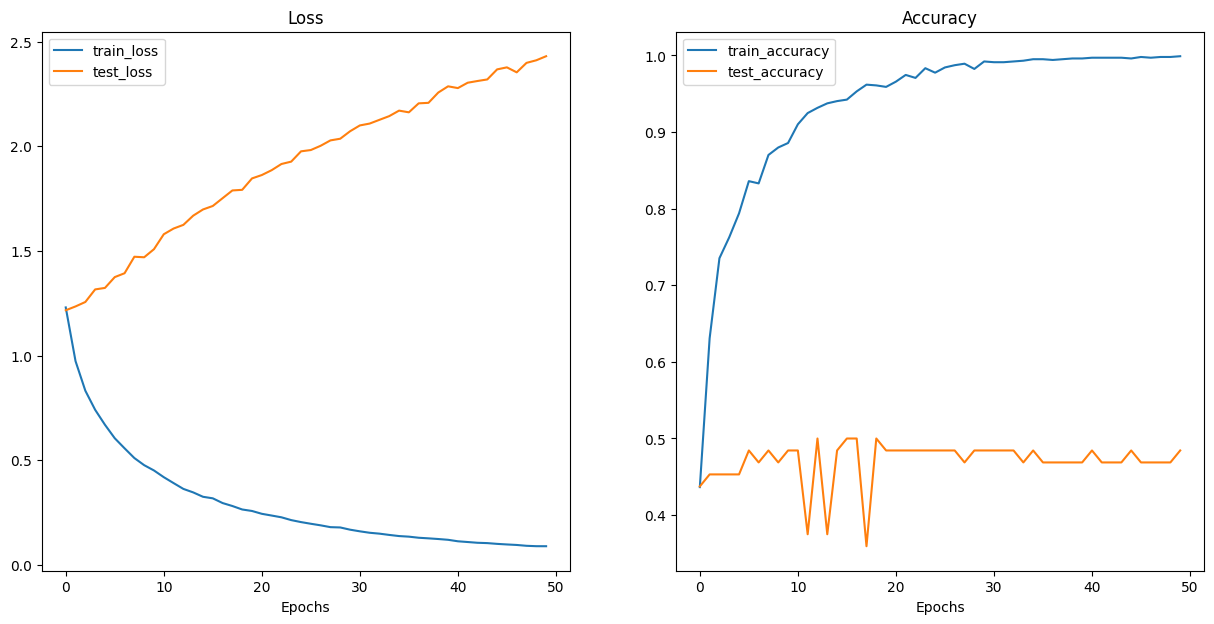

In [16]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

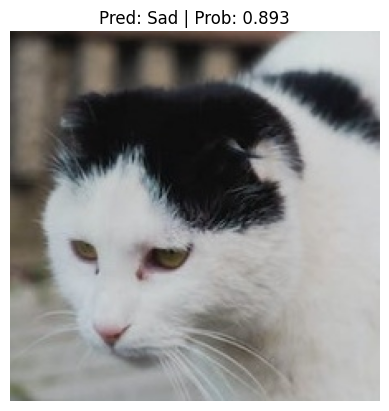

In [17]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image


custom_image_path = "/content/drive/MyDrive/Pet_Facial/Master Folder/valid/Sad/015.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [18]:
torch.save(pretrained_vit, 'pretrained_vit_model_full.pth')
